In [1]:
import numpy as np
import math
import time
from datetime import datetime, timezone
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

In [2]:
heart_rates = pd.read_csv('heart_rates.csv')
heart_rates['time'] = pd.to_datetime(heart_rates['time'])

In [3]:
steps = pd.read_csv('steps.csv')
steps['time'] = pd.to_datetime(steps['time'])

In [4]:
labels = pd.read_csv('labels.csv')
labels['time'] = pd.to_datetime(labels['time'])
labels.head()

,time,sleep,ID
0,2023-12-10 22:00:30,0,3509524
1,2023-12-10 22:01:00,0,3509524
2,2023-12-10 22:01:30,0,3509524
3,2023-12-10 22:02:00,0,3509524
4,2023-12-10 22:02:30,0,3509524


In [22]:
accelerations = pd.read_csv('accelerations.csv')
accelerations['time'] = pd.to_datetime(accelerations['time'])
accelerations.head()

,time,x,y,z,ID
0,2023-12-10 22:00:30.017312050,0.376553,0.902454,0.776656,46343
1,2023-12-10 22:00:30.037297964,0.375726,0.899671,0.781244,46343
2,2023-12-10 22:00:30.057515144,0.376503,0.900401,0.784297,46343
3,2023-12-10 22:00:30.077198982,0.379463,0.902950,0.779503,46343
4,2023-12-10 22:00:30.097036839,0.378901,0.905098,0.783409,46343


## Sleep + HR + Acceleration visualization

In [ ]:

for _, (subject_id, subject_labels) in enumerate(labels.groupby('ID')):

    print('subject id: {}'.format(subject_id))
    start = subject_labels['time'].min()
    end = subject_labels['time'].max()
    
    subject_hr = heart_rates[
        (heart_rates['time'] >= start)
        & (heart_rates['time'] <= end)
        & (heart_rates['ID'] == subject_id)
    ]
    subject_acc = accelerations[(accelerations['ID'] == subject_id)]
    plt.figure()
    plt.plot(subject_labels['time'], subject_labels['sleep'], label='Sleep', alpha=0.5)
    plt.plot(subject_hr['time'], subject_hr['heart_rate'], label='Heart rate', alpha=0.5)
    plt.plot(subject_acc['time'], subject_acc['x'], label='Acceleration x', alpha=0.5)
    plt.plot(subject_acc['time'], subject_acc['y'], label='Acceleration y', alpha=0.5)
    plt.plot(subject_acc['time'], subject_acc['z'], label='Acceleration z', alpha=0.5)
    plt.xlabel('time')
    plt.title(subject_id)
    plt.legend()

plt.show()


In [12]:
unique_values, counts = np.unique(labels['sleep'], return_counts=True)

# Display the counts for each unique value
for value, count in zip(unique_values, counts):
    print(f"Value {value} appears {count} times.")

Value -1 appears 418 times.
Value 0 appears 2418 times.
Value 1 appears 1821 times.
Value 2 appears 12954 times.
Value 3 appears 3329 times.
Value 4 appears 356 times.
Value 5 appears 5884 times.


# Modelling

In [13]:
def add_label(df, label, sub_id, start, end):
    condition = (df['time']>= start) & (df['time'] <= end) & (df['ID'] == sub_id)
    df.loc[condition, 'sleep'] = label
    return df

In [14]:
def check_sizes(X, Y):
    lengths = [len(inner_array) for inner_array in X]

    unique_values, counts = np.unique(lengths, return_counts=True)

    # Display the counts for each unique value
    for value, count in zip(unique_values, counts):
        print(f"Value {value} appears {count} times. percentage")

    print(len(Y))
    print(len(X))

In [15]:
def check_count(X):
    unique_values, counts = np.unique(X, return_counts=True)

    # Display the counts for each unique value
    for value, count in zip(unique_values, counts):
        print(f"Value {value} appears {count} times. percentage: {round(count*100 / len(X), 2)}")
        
    

In [16]:
def eval(test, pred):
    # Evaluate the model
    accuracy = accuracy_score(test, pred)
    print("Accuracy:", accuracy)

    # Display classification report
    print("Classification Report:")
    print(classification_report(test, pred))
    cm = confusion_matrix(test, pred)

    #Printing the accuracy
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [17]:
check_count(labels['sleep'])

Value -1 appears 418 times. percentage: 1.54
Value 0 appears 2418 times. percentage: 8.9
Value 1 appears 1821 times. percentage: 6.7
Value 2 appears 12954 times. percentage: 47.66
Value 3 appears 3329 times. percentage: 12.25
Value 4 appears 356 times. percentage: 1.31
Value 5 appears 5884 times. percentage: 21.65


In [18]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

In [178]:
def create_XY_sleep_wake(seq_length):
    hr_copy = heart_rates.copy()
    labels_copy =labels.copy()
    
    hr_copy['sleep'] = None
    
    labels_copy['sleep'] = labels_copy['sleep'].replace(-1,0)
    labels_copy['sleep'] = labels_copy['sleep'].replace(2,1)
    labels_copy['sleep'] = labels_copy['sleep'].replace(3,1)
    labels_copy['sleep'] = labels_copy['sleep'].replace(4,1)
    labels_copy['sleep'] = labels_copy['sleep'].replace(5,1)
    
    for idx, (subject_id, subject_labels) in enumerate(labels_copy.groupby('ID')):
        label = 0
        start = subject_labels['time'].min()
        end = start
        for _, row in subject_labels.iterrows():
            current_label = row['sleep']
            if (current_label != label):
                #new sleep stage => add previous sleep stages
                hr_copy = add_label(hr_copy, label, subject_id, start, end)
                start = row['time']
                label=row['sleep']

            end=row['time']
            
    l1 = len(hr_copy)
    hr_copy = hr_copy.dropna()
    l2 = len(hr_copy)
    print('number of removed rows: ', l1 - l2)
    
    X = []
    Y = []
    for i, (group, group_df) in enumerate(hr_copy.groupby(['ID', 'sleep'])):
        #print('idx: {}'.format(i))
        label = group_df.iloc[0]['sleep']
        x = create_sequences(group_df['heart_rate'], seq_length)
        y = np.full(len(x), label)
        if i == 0:
            X = x
        else:
            X = np.concatenate((X, x), axis = 0)
        Y.extend(y)
    return X, Y
    

## Model 1 (sleep vs awake)

In [179]:
X, Y = create_XY_sleep_wake(6)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y, test_size=0.2, random_state=42)

number of removed rows:  85078


In [181]:
check_count(y_train1)
check_count(y_test1)

Value 0 appears 10809 times. percentage: 7.99
Value 1 appears 124395 times. percentage: 92.01
Value 0 appears 2685 times. percentage: 7.94
Value 1 appears 31117 times. percentage: 92.06


In [186]:
classifier1 = MLPClassifier(
    activation='relu',
    hidden_layer_sizes=(64,64,32),
    max_iter=100,
    alpha=0.01,
    solver='adam'
)

classifier1.fit(X_train1, y_train1)
y_pred1 = classifier1.predict(X_test1)

In [194]:
check_count(y_pred1)
check_count(y_test1)

Value 0 appears 8 times. percentage: 0.02
Value 1 appears 33794 times. percentage: 99.98
Value 0 appears 2685 times. percentage: 7.94
Value 1 appears 31117 times. percentage: 92.06


[[    5     3]
 [ 2680 31114]]
accuracy score: 0.9206259984616295


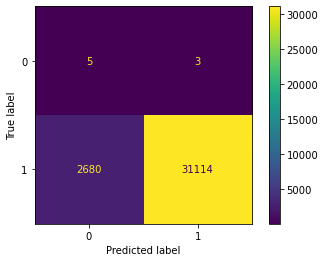

In [192]:
cm1 = confusion_matrix(y_pred1, y_test1)

#Printing the accuracy
print(cm1)
print("accuracy score: {}".format(accuracy_score(y_test1, y_pred1)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()
plt.show()

number of removed rows:  85078
[[   15     8]
 [ 2584 31083]]
accuracy score: 0.9230632235084595


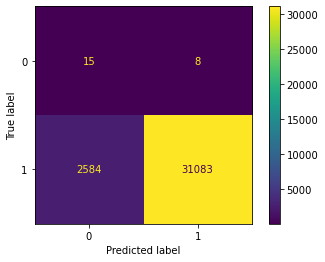

In [196]:
X, Y = create_XY_sleep_wake(15)
X_train1_b, X_test1_b, y_train1_b, y_test1_b = train_test_split(X, Y, test_size=0.2, random_state=42)

classifier1_b = MLPClassifier(
    activation='relu',
    hidden_layer_sizes=(64,64,32),
    max_iter=100,
    alpha=0.01,
    solver='adam'
)

classifier1_b.fit(X_train1_b, y_train1_b)
y_pred1_b = classifier1_b.predict(X_test1_b)

cm1_b = confusion_matrix(y_pred1_b, y_test1_b)

#Printing the accuracy
print(cm1_b)
print("accuracy score: {}".format(accuracy_score(y_test1_b, y_pred1_b)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm1_b)
disp.plot()
plt.show()

## Model 2 (sleep stages)

In [188]:
def create_XY_sleep_stages(seq_length):
    hr_copy = heart_rates.copy()
    labels_copy =labels.copy()
    
    hr_copy['sleep'] = None
    labels_copy['sleep'] = labels_copy['sleep'].replace(-1,0)


    for idx, (subject_id, subject_labels) in enumerate(labels_copy.groupby('ID')):
        label = 0
        start = subject_labels['time'].min()
        end = start
        for _, row in subject_labels.iterrows():
            current_label = row['sleep']
            if (current_label != label):
                #new sleep stage => add previous sleep stages
                hr_copy = add_label(hr_copy, label, subject_id, start, end)
                start = row['time']
                label=row['sleep']

            end=row['time']
    
    l1 = len(hr_copy)
    hr_copy = hr_copy.dropna()
    l2 = len(hr_copy)
    print('number of removed rows: ', l1 - l2)
            
    X = []
    Y = []
    for i, (group, group_df) in enumerate(hr_copy.groupby(['ID', 'sleep'])):
        #print('idx: {}'.format(i))
        label = group_df.iloc[0]['sleep']
        x = create_sequences(group_df['heart_rate'], seq_length)
        y = np.full(len(x), label)
        if i == 0:
            X = x
        else:
            X = np.concatenate((X, x), axis = 0)
        Y.extend(y)
    return X, Y

In [189]:
X_2a, Y_2a = create_XY_sleep_stages(10)
X_train_2a, X_test_2a, y_train_2a, y_test_2a = train_test_split(X_2a, Y_2a, test_size=0.2, random_state=42)
check_count(y_train_2a)
check_count(y_test_2a)

number of removed rows:  96890
Value 0 appears 10674 times. percentage: 8.55
Value 1 appears 5779 times. percentage: 4.63
Value 2 appears 62574 times. percentage: 50.11
Value 3 appears 14582 times. percentage: 11.68
Value 4 appears 1488 times. percentage: 1.19
Value 5 appears 29783 times. percentage: 23.85
Value 0 appears 2696 times. percentage: 8.64
Value 1 appears 1401 times. percentage: 4.49
Value 2 appears 15327 times. percentage: 49.09
Value 3 appears 3816 times. percentage: 12.22
Value 4 appears 400 times. percentage: 1.28
Value 5 appears 7580 times. percentage: 24.28


In [190]:
classifier_2a = MLPClassifier(
    activation='relu',
    hidden_layer_sizes=(64,64,32,16),
    max_iter=100,
    alpha=0.01,
    solver='adam'
)

classifier_2a.fit(X_train_2a, y_train_2a)
y_pred_2a = classifier_2a.predict(X_test_2a)

C:\Users\juho\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[[  282    89    84     7     3   135]
 [   62   162    70     0     0    87]
 [ 1588   879 13878  3339   319  4972]
 [   52    11   122   354    56    66]
 [    0     0     0     0     0     0]
 [  712   260  1173   116    22  2320]]
accuracy score: 0.5443946188340807


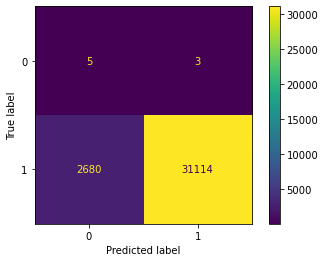

In [195]:
cm_2a = confusion_matrix(y_pred_2a, y_test_2a)

#Printing the accuracy
print(cm_2a)
print("accuracy score: {}".format(accuracy_score(y_test_2a, y_pred_2a)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()
plt.show()

# Model 3 RFC

In [209]:
X, Y = create_XY_sleep_wake(6)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, Y, test_size=0.2, random_state=42)


number of removed rows:  85078


In [210]:
check_count(y_train3)
check_count(y_test3)

Value 0 appears 10809 times. percentage: 7.99
Value 1 appears 124395 times. percentage: 92.01
Value 0 appears 2685 times. percentage: 7.94
Value 1 appears 31117 times. percentage: 92.06


In [211]:
rf_classifier = RandomForestClassifier(n_estimators=6, random_state=42)

# Train the classifier
rf_classifier.fit(X_train3, y_train3)

# Make predictions on the test set
y_pred3 = rf_classifier.predict(X_test3)

Accuracy: 0.9121649606532158
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.20      0.27      2685
           1       0.93      0.97      0.95     31117

    accuracy                           0.91     33802
   macro avg       0.66      0.59      0.61     33802
weighted avg       0.89      0.91      0.90     33802

[[  539  2146]
 [  823 30294]]


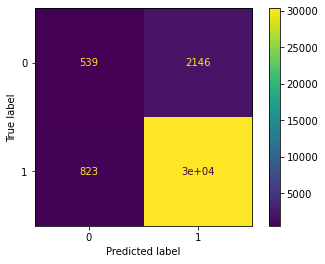

In [212]:
eval(y_test3, y_pred3)

# Model 4 (Support Vector Machines)

In [213]:
X, Y = create_XY_sleep_wake(6)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, Y, test_size=0.2, random_state=42)


number of removed rows:  85078


In [214]:
check_count(y_train4)
check_count(y_test4)

Value 0 appears 10809 times. percentage: 7.99
Value 1 appears 124395 times. percentage: 92.01
Value 0 appears 2685 times. percentage: 7.94
Value 1 appears 31117 times. percentage: 92.06


In [215]:
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

svm_classifier.fit(X_train4, y_train4)


y_pred4 = svm_classifier.predict(X_test4)

Accuracy: 0.9205668303650671
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2685
           1       0.92      1.00      0.96     31117

    accuracy                           0.92     33802
   macro avg       0.46      0.50      0.48     33802
weighted avg       0.85      0.92      0.88     33802

[[    0  2685]
 [    0 31117]]


C:\Users\juho\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


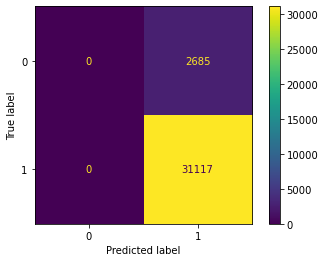

In [216]:
eval(y_test4, y_pred4)

# Add accelerations to sequence

In [23]:

def create_XY_sleep_wake_with_acc(seq_length):
    #hr_copy = heart_rates.copy()
    acc_copy = accelerations.copy()
    labels_copy =labels.copy()
    
    #hr_copy['sleep'] = None
    acc_copy['sleep'] = None
    
    labels_copy['sleep'] = labels_copy['sleep'].replace(-1,0)
    labels_copy['sleep'] = labels_copy['sleep'].replace(2,1)
    labels_copy['sleep'] = labels_copy['sleep'].replace(3,1)
    labels_copy['sleep'] = labels_copy['sleep'].replace(4,1)
    labels_copy['sleep'] = labels_copy['sleep'].replace(5,1)
     
    X = []
    Y = []
    
    first = True
    
    for idx, (_, subject_labels) in enumerate(labels_copy.groupby('ID')):
        print('index: {}'.format(idx))
        subject_id = subject_labels.iloc[0]['ID']
        
        acc = acc_copy[acc_copy['ID'] == subject_id]
        
        for _, (_, label_group) in enumerate(subject_labels.groupby('sleep')):
            label= label_group.iloc[0]['sleep']
        
            start = label_group['time'].min()
            end = label_group['time'].max()
        
            condition = (acc['time']>= start) & (acc['time'] <= end)
            filtered = acc[condition]
            x = create_sequences(filtered['x'], seq_length)
            y = np.full(len(x), label)
            
            if first:
                X = x
                first = False
            else:
                X = np.concatenate((X, x), axis = 0)
            Y.extend(y)
        
        break
            
    return X, Y


    


In [24]:
X, Y = create_XY_sleep_wake_with_acc(20)
X_train5, X_test5, y_train5, y_test5 = train_test_split(X, Y, test_size=0.2, random_state=42)

index: 0


In [25]:
check_count(y_train5)
check_count(y_test5)

Value 0 appears 677105 times. percentage: 53.76
Value 1 appears 582363 times. percentage: 46.24
Value 0 appears 169132 times. percentage: 53.72
Value 1 appears 145736 times. percentage: 46.28


In [37]:
n = 10**6
X_train5_small = X_train5[:n]
X_test5_small = X_test5[:n]
y_train5_small = y_train5[:n]
y_test5_small = y_test5[:n]

In [38]:
rf_classifier_acc = RandomForestClassifier(n_estimators=20, random_state=42)

# Train the classifier
rf_classifier_acc.fit(X_train5_small, y_train5_small)

# Make predictions on the test set
y_pred5_small = rf_classifier_acc.predict(X_test5_small)



Accuracy: 0.2433527700496716
Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.31      0.30    169132
           1       0.17      0.17      0.17    145736

    accuracy                           0.24    314868
   macro avg       0.24      0.24      0.24    314868
weighted avg       0.24      0.24      0.24    314868

[[ 51962 117170]
 [121074  24662]]


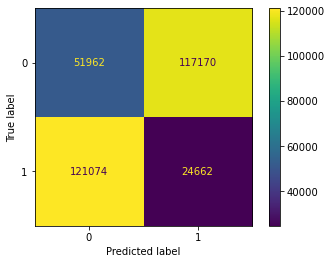

In [39]:
eval(y_test5_small, y_pred5_small)

In [ ]:
n = 10**3
X_train5_small = X_train5[:n]
X_test5_small = X_test5[:n]
y_train5_small = y_train5[:n]
y_test5_small = y_test5[:n]

In [ ]:
eval(y_test5_small, y_pred5_small)

In [ ]:
accelerations['sleep']= 0

for idx, (subject_id, subject_labels) in enumerate(labels.groupby('ID')):
    print('index: {}'.format(idx))
    label = -1
    start = subject_labels['time'].min()
    end = start
    for _, row in subject_labels.iterrows():
        current_label = row['sleep']
        if (current_label != label):
            #new sleep stage => add previous sleep stages
            accelerations = add_label(accelerations, label, subject_id, start, end)
            start = row['time']
            label=row['sleep']
            
        end=row['time']